# ターボファンエンジンの診断システム構築

## 目的
- ターボファンエンジンの診断システムを構築する
    - システムの機能：
        - エンジンの現状把握（センサーデータの可視化）
        - 故障までのデータがない場合、異常検知手法も用いてエンジンの状態警告モデル
        - 故障までのデータがある場合、エンジンの状態を分類するモデル
        - 故障までのデータがある場合、エンジンの残存耐用期間（RUL）予測モデル

## このノートブックの目的
- データセットの全プロファイルを作成
- センサーデータを可視化する

## インポート

In [1]:
# !pip install pandas_profiling

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas_profiling import ProfileReport
import gc
from pathlib import Path

/Users/thaiha_nguyen/opt/miniconda3/envs/abnorm_detec_py3813/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# import warnings
# warnings.filterwarnings('ignore')

## データ読み込み

In [4]:
# data path
data_dir = Path("../data/CMaps")
train_raw_dir = data_dir / "train_FD001.txt"
test_raw_dir = data_dir / "test_FD001.txt"
rul_raw_dir = data_dir / "RUL_FD001.txt"

In [5]:
# adding columns' name
variable_names = ['Unit','Time', 'setting_1', 'setting_2', 'setting_3',
                  'FanInletTemp', 'LPCOutletTemp', 'HPCOutletTemp', 'LPTOutletTemp', 'FanInletPres', 
                  'BypassDuctPres', 'TotalHPCOutletPres','PhysFanSpeed','PhysCoreSpeed', 'EnginePresRatio', 
                  'StaticHPCOutletPres', 'FuelFlowRatio', 'CorrFanSpeed', 'CorrCoreSpeed', 'BypassRatio',
                  'BurnerFuelAirRatio','BleedEnthalpy', 'DemandFanSpeed', 'DemandCorrFanSpeed', 'HPTCoolantBleed', 
                  'LPTCoolantBleed']

In [6]:
# columns' group
index_names = ['Unit', 'Time']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = variable_names[5:]

In [7]:
train_df = pd.read_csv(train_raw_dir, 
                    sep='\s+', 
                    header=None,
                    index_col=False,
                    names=variable_names)
train = train_df.copy()

test_df = pd.read_csv(test_raw_dir, 
                    sep='\s+', 
                    header=None,
                    index_col=False,
                    names=variable_names)
test = test_df.copy()

y_test = pd.read_csv(rul_raw_dir, 
                     sep='\s+', 
                     header=None,
                     index_col=False,
                     names=['RUL'])

In [8]:
train.head()

,Unit,Time,setting_1,setting_2,setting_3,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,...,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BurnerFuelAirRatio,BleedEnthalpy,DemandFanSpeed,DemandCorrFanSpeed,HPTCoolantBleed,LPTCoolantBleed
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## 基礎集計

In [9]:
# pandas_profilingを用いて、データの基礎集計を作成する
train_profile = ProfileReport(train, title="Pandas Profiling Report", minimal=True)

In [10]:
# export profile to html
train_profile.to_file(Path("../html/train_data_FD001_profile.html"))

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 884.87it/s]


In [11]:
# check for NAN values
train.isnull().sum()
# Output: 欠損値が存在しない

Unit                   0
Time                   0
setting_1              0
setting_2              0
setting_3              0
FanInletTemp           0
LPCOutletTemp          0
HPCOutletTemp          0
LPTOutletTemp          0
FanInletPres           0
BypassDuctPres         0
TotalHPCOutletPres     0
PhysFanSpeed           0
PhysCoreSpeed          0
EnginePresRatio        0
StaticHPCOutletPres    0
FuelFlowRatio          0
CorrFanSpeed           0
CorrCoreSpeed          0
BypassRatio            0
BurnerFuelAirRatio     0
BleedEnthalpy          0
DemandFanSpeed         0
DemandCorrFanSpeed     0
HPTCoolantBleed        0
LPTCoolantBleed        0
dtype: int64

In [12]:
# inspect engine unit and time cycles
train[index_names].describe().T

,count,mean,std,min,25%,50%,75%,max
Unit,20631.0,51.506568,29.227633,1.0,26.0,52.0,77.0,100.0
Time,20631.0,108.807862,68.880990,1.0,52.0,104.0,156.0,362.0


In [13]:
# inspect time cycles
train[index_names].groupby('Unit').max().describe().T

,count,mean,std,min,25%,50%,75%,max
Time,100.0,206.31,46.342749,128.0,177.0,199.0,229.25,362.0


In [14]:
# inspect settings
train[setting_names].describe().T

,count,mean,std,min,25%,50%,75%,max
setting_1,20631.0,-0.000009,0.002187,-0.0087,-0.0015,0.0,0.0015,0.0087
setting_2,20631.0,0.000002,0.000293,-0.0006,-0.0002,0.0,0.0003,0.0006
setting_3,20631.0,100.000000,0.000000,100.0000,100.0000,100.0,100.0000,100.0000


In [15]:
# sensor values
train[sensor_names].describe().T

,count,mean,std,min,25%,50%,75%,max
FanInletTemp,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
LPCOutletTemp,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
HPCOutletTemp,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
LPTOutletTemp,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
FanInletPres,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
BypassDuctPres,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
TotalHPCOutletPres,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
PhysFanSpeed,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
PhysCoreSpeed,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
EnginePresRatio,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


In [16]:
train[sensor_names].shape

(20631, 21)

In [17]:
# add the sensor index with corresponding sensor name
sensor_index = [f"s_{i}" for i in range(1,22)]
sensor_dict = {key: value for key, value in zip(sensor_index, sensor_names)}

In [18]:
print(sensor_dict)

{'s_1': 'FanInletTemp', 's_2': 'LPCOutletTemp', 's_3': 'HPCOutletTemp', 's_4': 'LPTOutletTemp', 's_5': 'FanInletPres', 's_6': 'BypassDuctPres', 's_7': 'TotalHPCOutletPres', 's_8': 'PhysFanSpeed', 's_9': 'PhysCoreSpeed', 's_10': 'EnginePresRatio', 's_11': 'StaticHPCOutletPres', 's_12': 'FuelFlowRatio', 's_13': 'CorrFanSpeed', 's_14': 'CorrCoreSpeed', 's_15': 'BypassRatio', 's_16': 'BurnerFuelAirRatio', 's_17': 'BleedEnthalpy', 's_18': 'DemandFanSpeed', 's_19': 'DemandCorrFanSpeed', 's_20': 'HPTCoolantBleed', 's_21': 'LPTCoolantBleed'}


## 残存耐用時間（RUL）を算出する

In [19]:
def add_remaining_useful_life(df: pd.DataFrame) -> pd.DataFrame:
    """残存耐用時間を追加する関数

    Args:
        df (pd.DataFrame): ローデータ

    Returns:
        pd.DataFrame: 残存耐用時間を追加したデータフレーム
    """

    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="Unit")
    max_cycle = grouped_by_unit["Time"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='Unit', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["Time"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,Unit,Time,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


## Plotting

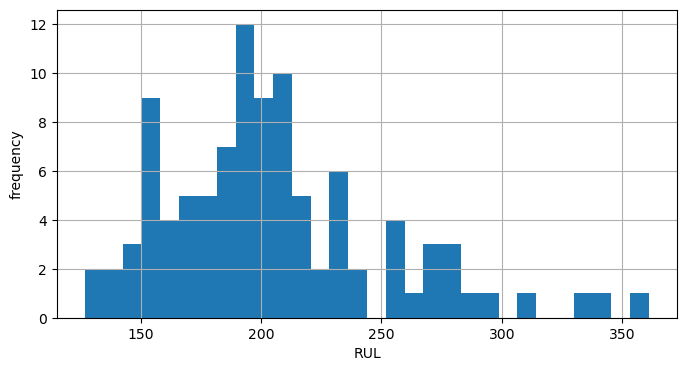

In [20]:
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = train[['Unit', 'RUL']].groupby('Unit').max().reset_index()
df_max_rul['RUL'].hist(bins=30, figsize=(8,4))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

20967

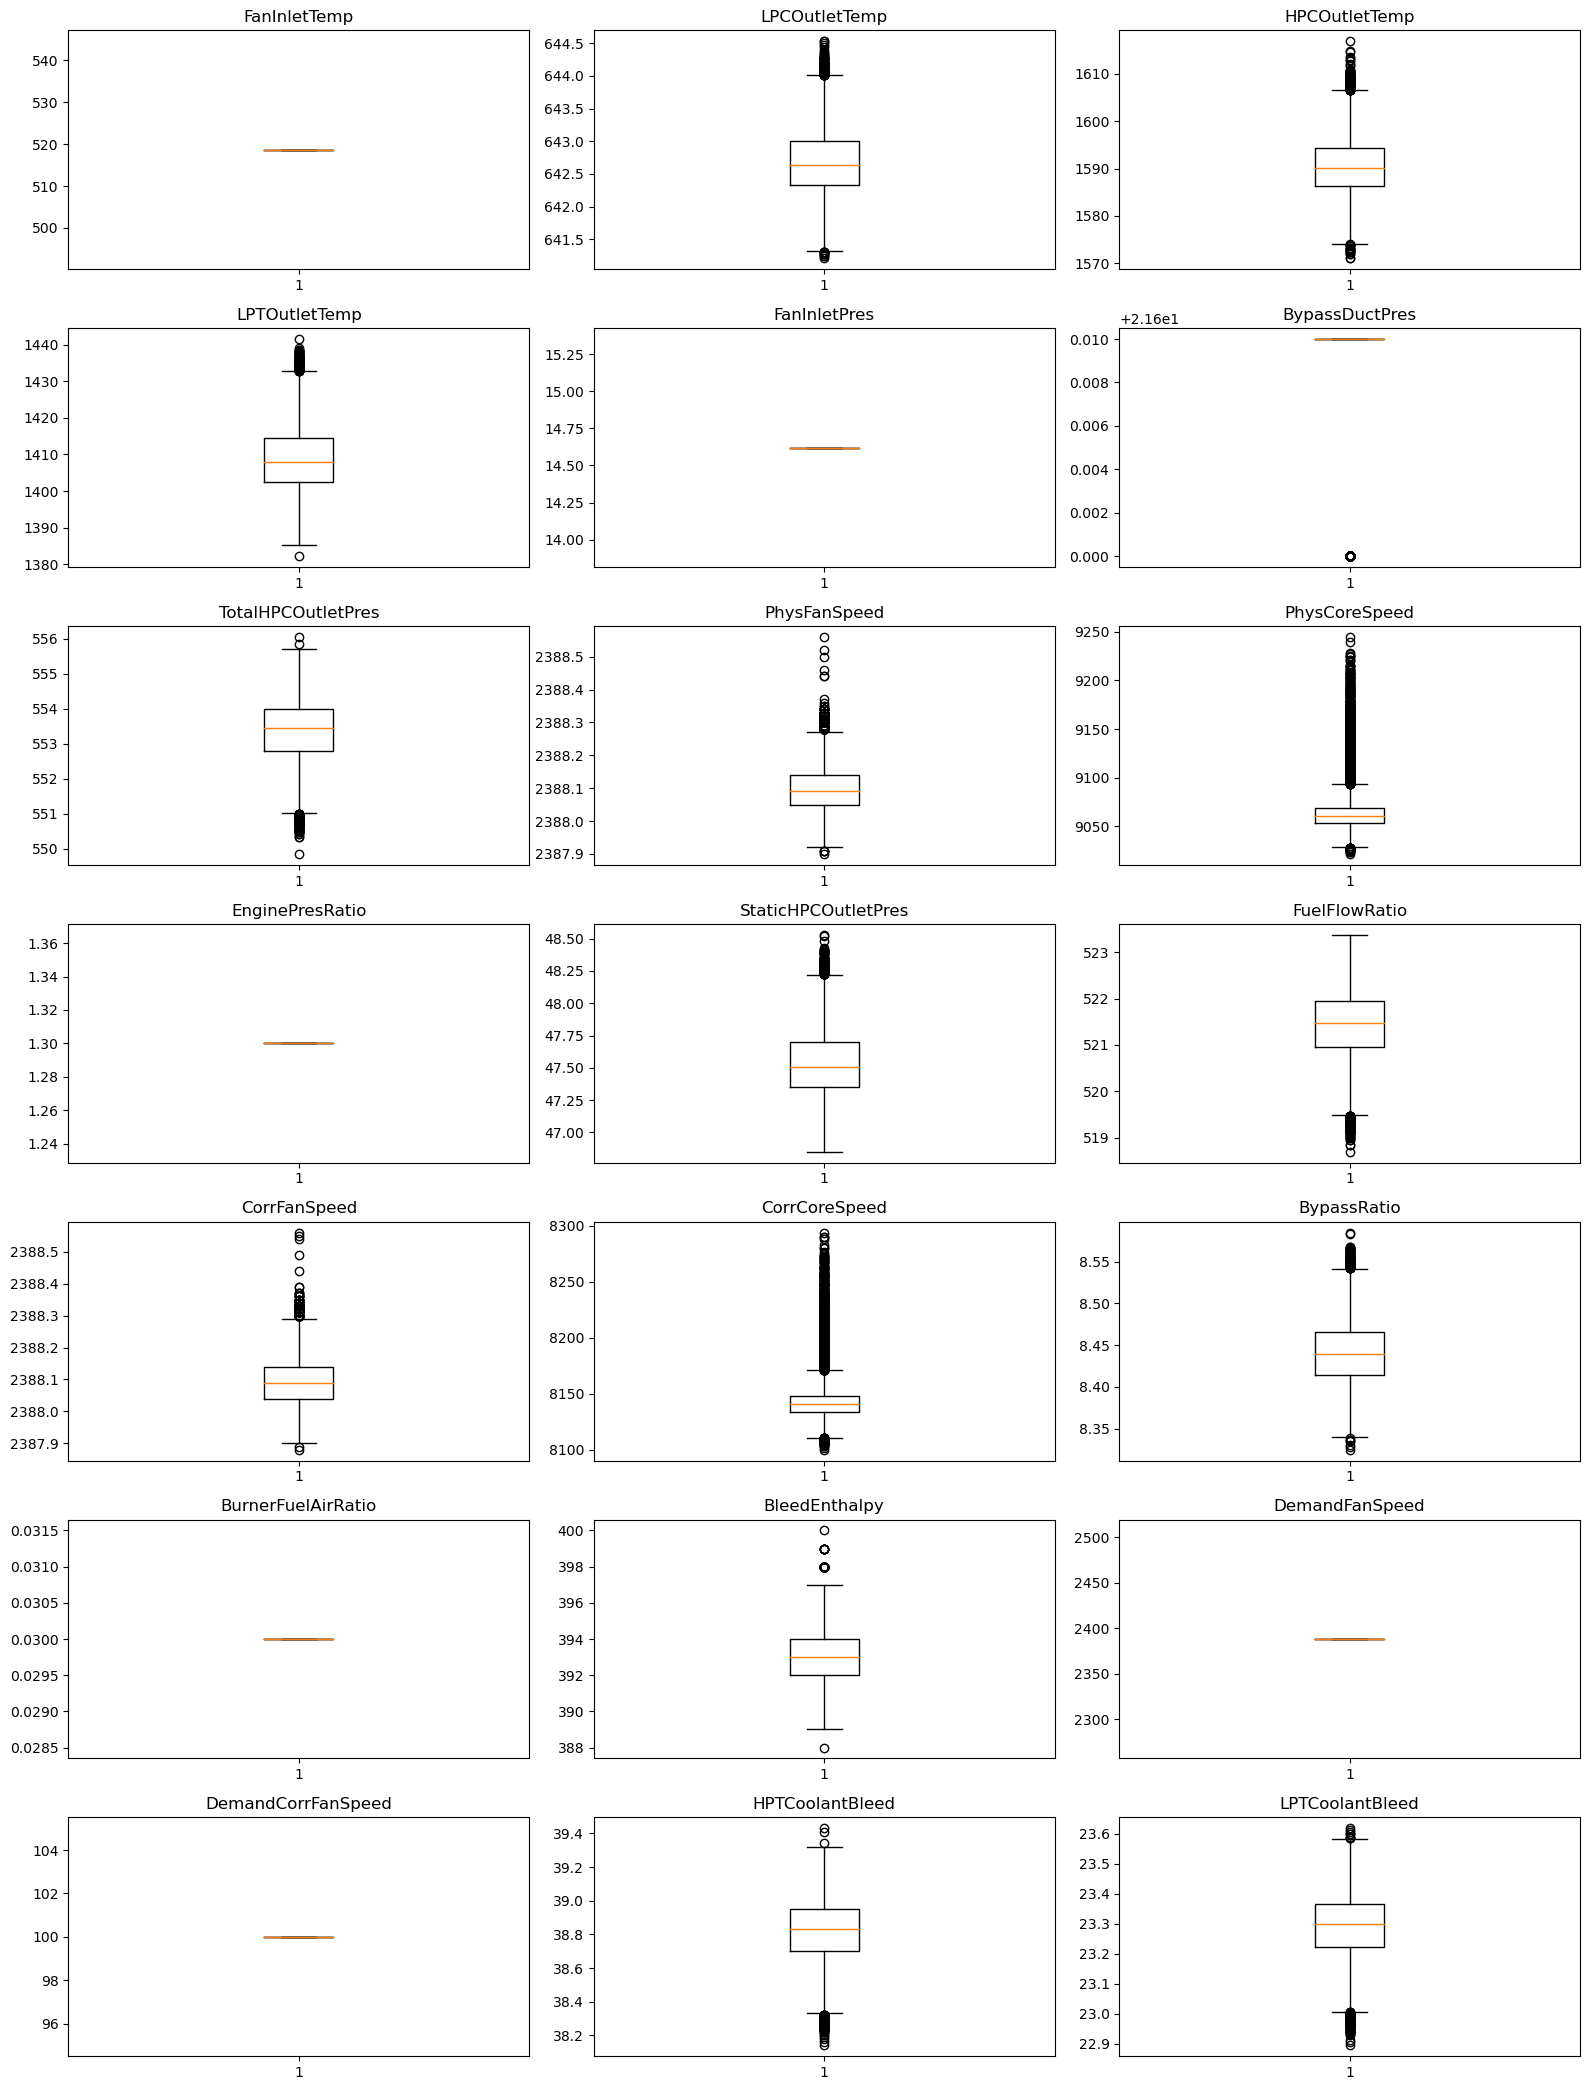

In [21]:
plt.figure(figsize = (16, 21))
for i in range(21):
    temp_data = train.iloc[:,i+5]
    plt.subplot(7,3,i+1)
    plt.boxplot(temp_data)
    plt.title(sensor_names[i])

plt.tight_layout();

del temp_data
gc.collect()

In [22]:
def plot_sensor(sensor_name, df):
    fig, ax = plt.subplots(figsize=(10,3))
    for i in df['Unit'].unique():
        if i % 10 == 0:
            ax.plot('RUL', sensor_name, data = df[df['Unit'] == i])
            ax.set_xlim([250,0])
    ax.set_ylabel(sensor_name)
    ax.set_xlabel('Remaining Useful Life')

/var/folders/nx/zg8x3j9172z1bl_8p_ss2vtm0000gq/T/ipykernel_22727/4156436499.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,3))


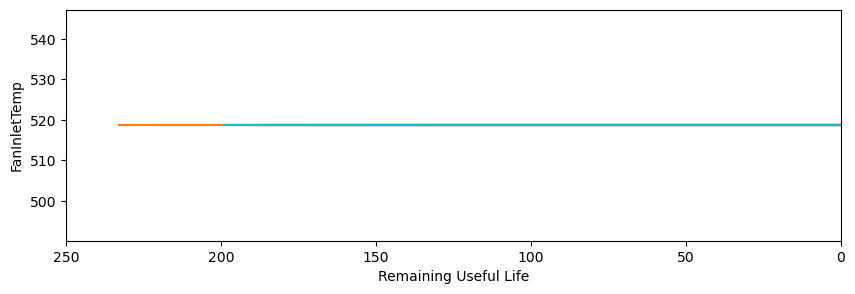

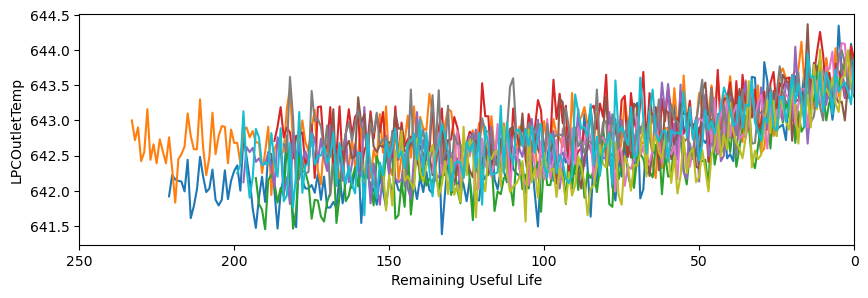

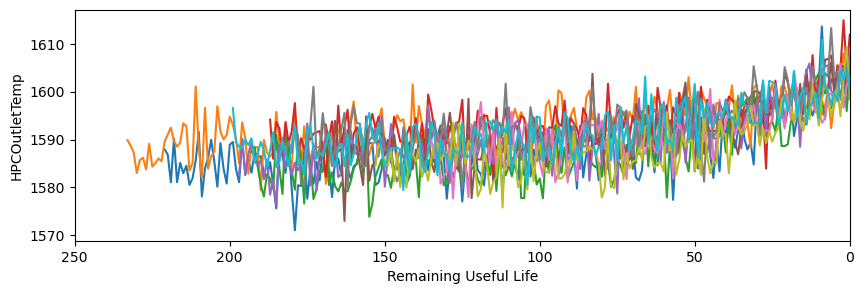

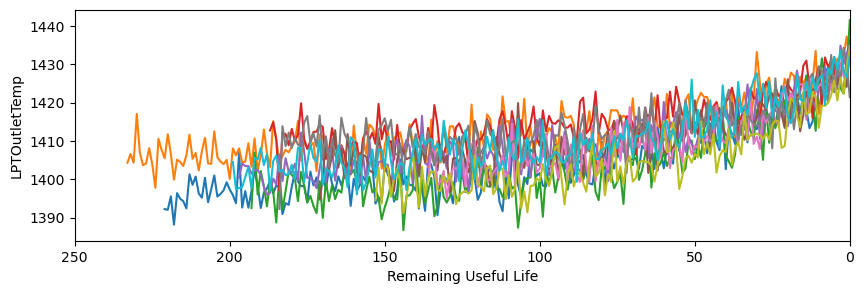

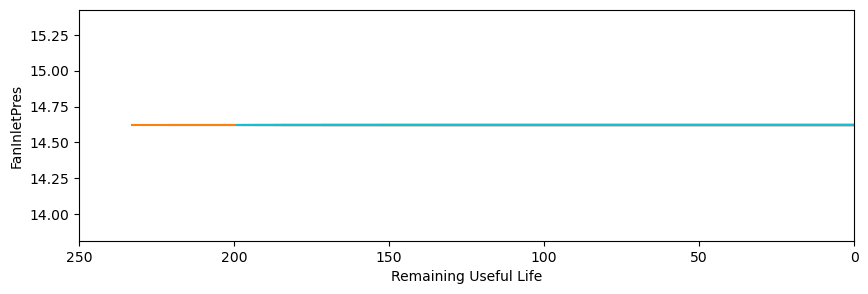

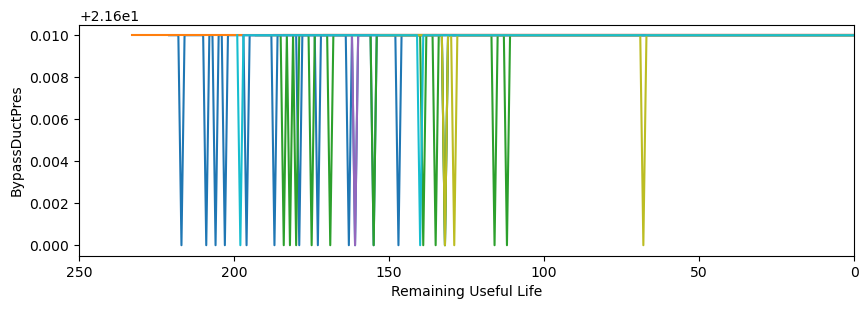

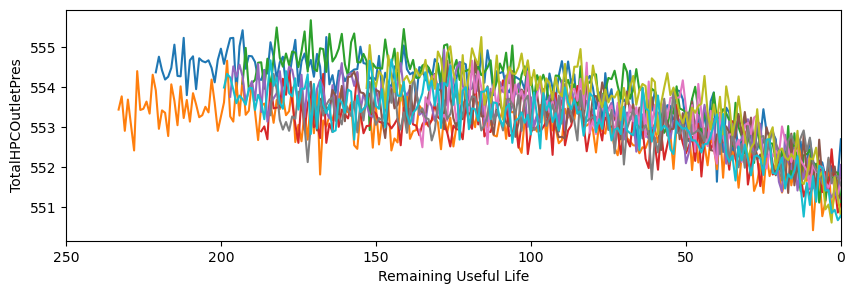

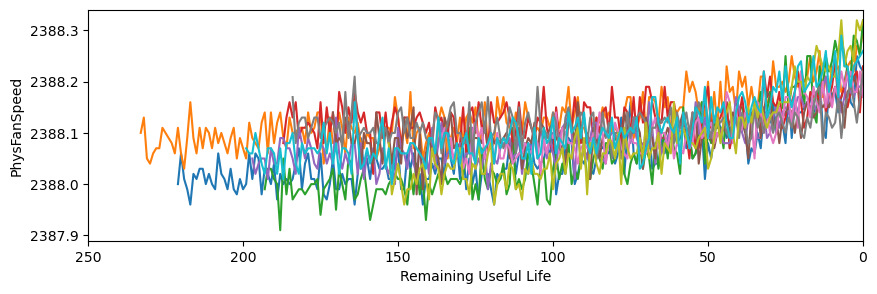

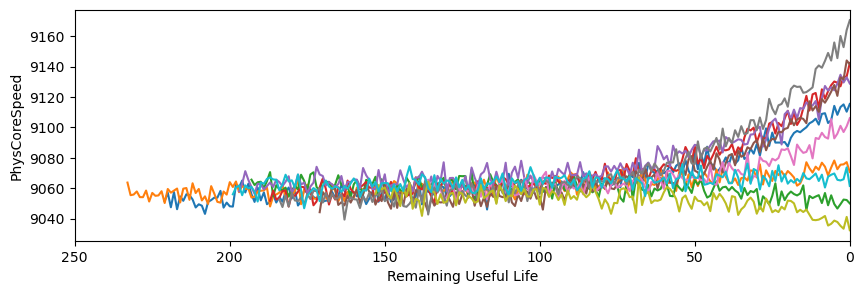

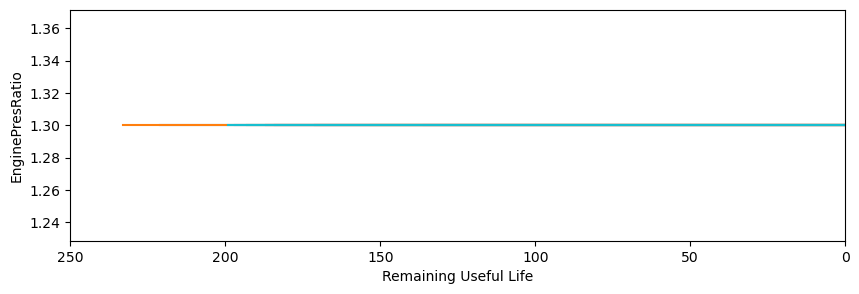

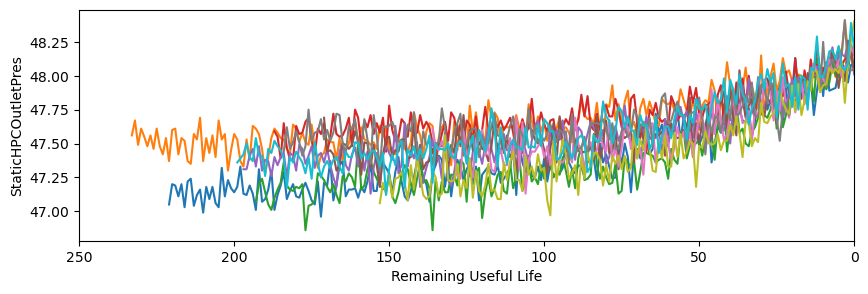

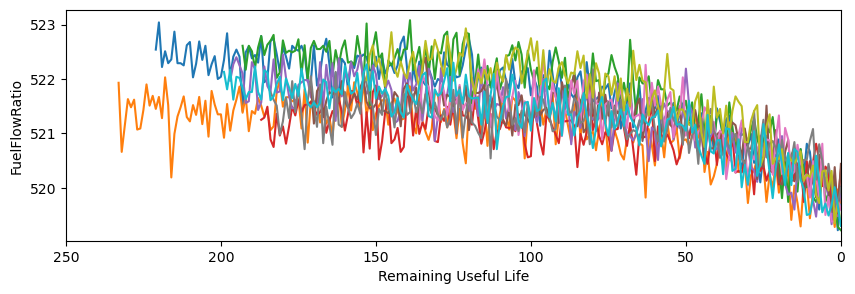

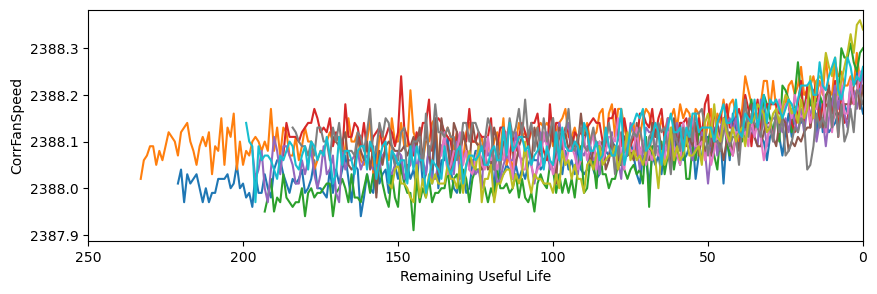

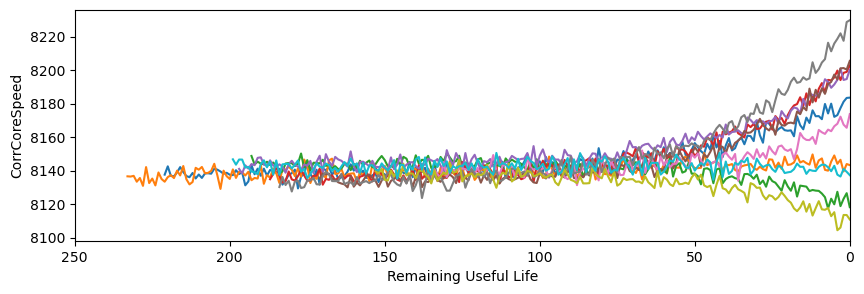

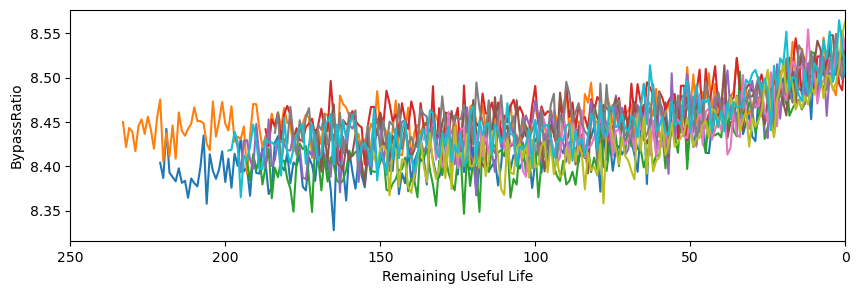

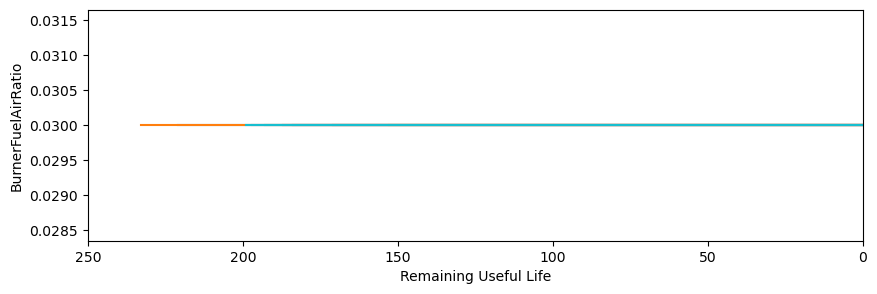

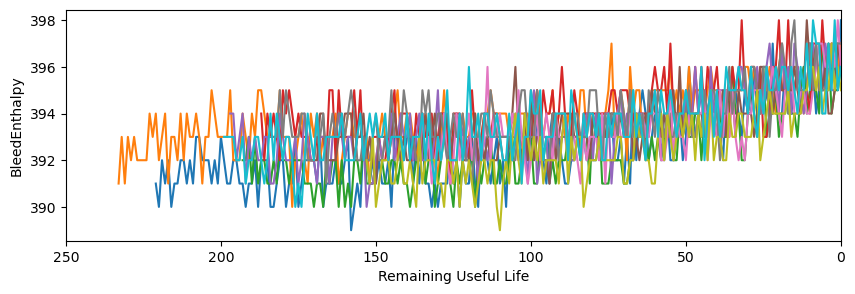

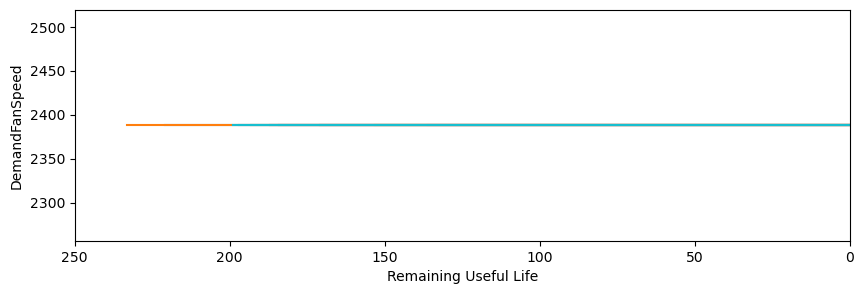

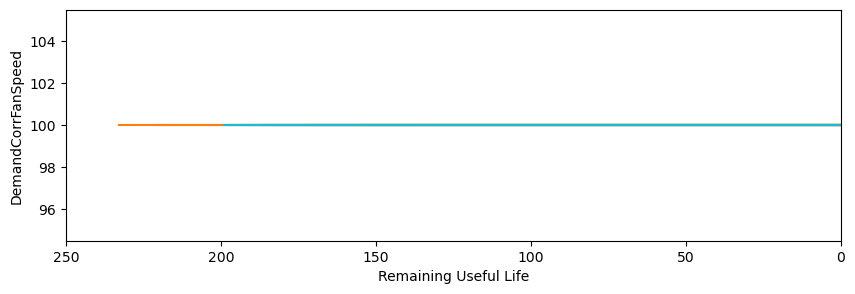

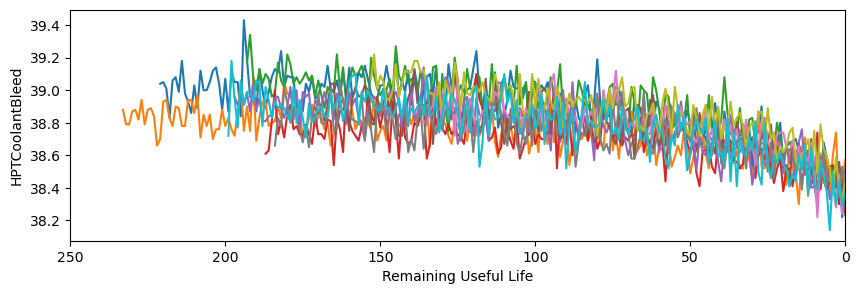

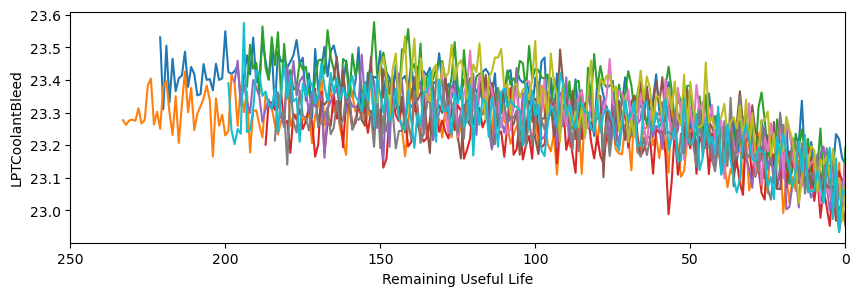

In [23]:
for sensor_name in sensor_names:
    plot_sensor(sensor_name, df=train);